In [ ]:
# import required libraries
!pip install yfinance
!pip install bs4
!pip install requests
!pip install ta
!pip install finta
!pip install mplfinance
import pandas as pd
import yfinance as yf
import numpy as np
import mplfinance as mpf
from ta.trend import ADXIndicator
#from google.colab import files
import io
import smtplib
from datetime import datetime
from pytz import timezone


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 81.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.17.0-py3-none-any.whl size=135721 sha256=f1cfd52e634f48600f9e8e08f5efc4eadede97d24f167faa4851530bcaebfe07
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Not uninst

1670/1908

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1671/1908

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1672/1908

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1673/1908

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1674/1908

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1675/1908

[*********************100%%**********

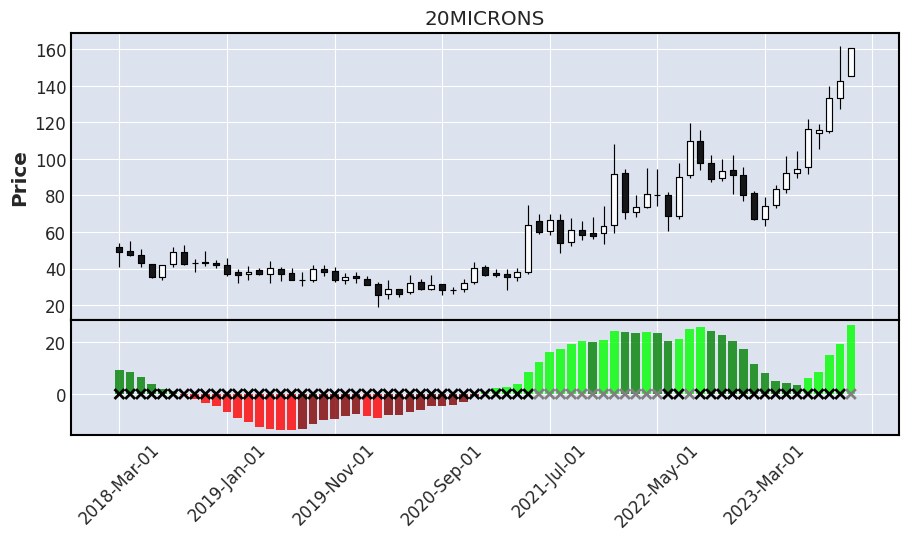

In [ ]:
# parameter setup
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5

url = 'https://raw.githubusercontent.com/CarvedCloud/Projects_Stocks/main/NSE_Stock_List.csv'
url1 = 'https://raw.githubusercontent.com/CarvedCloud/Projects_Stocks/main/NSE_F%26O_List.csv'

format = "%d/%m/%Y  %H:%M:%S %Z%z"
format1 = "%Y-%m-%d"
now_utc = datetime.now(timezone('UTC'))
now_asia = now_utc.astimezone(timezone('Asia/Kolkata'))
edate=now_asia.strftime(format1)
temp=int(edate[:4])-1
sdate=str(temp)+edate[4:]


s=0
c=0
ve=0
screened_list_buy = []
screened_list_buy_futures = []
screened_list_sell = []
screened_list_buy_52weekhigh = []
long_term_buy_list = []
weekly_option_entry_list = []
el = []
fl = []

stocks = pd.read_csv(url)
stock_codes=stocks.filter(["SYMBOL"])
stock_list=stock_codes.values

stocks2 = pd.read_csv(url1,encoding = 'unicode_escape')
stock_codes2=stocks2.filter(["SYMBOL"])
stock_list2=stock_codes2.values
for i in stock_list2:
  fl.append(i[0])

for stock_code in stock_list:
    for i in ["daily","monthly","weekly"]:
        try:
            # get stock prices
            # stock_code_temp = yf.Ticker(stock_code[0])
            # df = stock_code_temp.history(period="3y")
            if i=='daily':
                df = yf.download(stock_code[0]+'.ns', start=sdate, threads= False)
            elif i=='monthly':
                df = yf.download(stock_code[0]+'.ns', start='2015-01-01', threads= False,interval='1mo')
            elif i=='weekly':
                if stock_code[0] not in fl:
                    continue
                else:
                    df = yf.download(stock_code[0]+'.ns', start='2020-01-01', threads= False,interval='1wk')
            m=df[:-2]["High"].max()
            lp=df["Close"][-1]

            if len(df)<5:
                continue

            # calculate BB
            m_avg = df['Close'].rolling(window=length).mean()
            m_std = df['Close'].rolling(window=length).std(ddof=0)
            df['upper_BB'] = m_avg + mult_KC * m_std
            df['lower_BB'] = m_avg - mult_KC * m_std

            # calculate true range
            df['tr0'] = abs(df["High"] - df["Low"])
            df['tr1'] = abs(df["High"] - df["Close"].shift())
            df['tr2'] = abs(df["Low"] - df["Close"].shift())
            df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

            # calculate KC
            range_ma = df['tr'].rolling(window=length_KC).mean()
            df['upper_KC'] = m_avg + range_ma * mult_KC
            df['lower_KC'] = m_avg - range_ma * mult_KC

            # calculate bar value
            highest = df['High'].rolling(window = length_KC).max()
            lowest = df['Low'].rolling(window = length_KC).min()
            m1 = (highest + lowest)/2
            df['value'] = (df['Close'] - (m1 + m_avg)/2)
            fit_y = np.array(range(0,length_KC))
            df['value'] = df['value'].rolling(window = length_KC).apply(lambda x:
                                      np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
                                      np.polyfit(fit_y, x, 1)[1], raw=True)

            # check for 'squeeze'
            df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
            df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

            # buying window for long position:
            # 1. black cross becomes gray (the squeeze is released)
            long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
            # 2. bar value is positive => the bar is light green k
            long_cond2 = df['value'][-1] > 0
            enter_long = long_cond1 and long_cond2

            # buying window for short position:
            # 1. black cross becomes gray (the squeeze is released)
            short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
            # 2. bar value is negative => the bar is light red
            short_cond2 = df['value'][-1] < 0
            enter_short = short_cond1 and short_cond2

            if enter_long | enter_short:

                #ADX Calculation
                df['Adj Open'] = df.Open * df['Adj Close']/df['Close']
                df['Adj High'] = df.High * df['Adj Close']/df['Close']
                df['Adj Low'] = df.Low * df['Adj Close']/df['Close']
                df.dropna(inplace=True)
                adxI = ADXIndicator(df['Adj High'],df['Adj Low'],df['Adj Close'],14,False)
                df['pos_directional_indicator'] = adxI.adx_pos()
                df['neg_directional_indicator'] = adxI.adx_neg()
                df['adx'] = adxI.adx()
                df.tail()

                if df['adx'].iloc[-1]>25:
                    if enter_long == True:
                        if i=='daily':
                            if lp>m:
                                screened_list_buy_52weekhigh.append(stock_code[0])  
                            if stock_code[0] in fl:
                                screened_list_buy_futures.append(stock_code[0])
                            else:
                                screened_list_buy.append(stock_code[0])
                        elif i=='monthly':
                            if lp>m:
                                long_term_buy_list.append(stock_code[0])
                        elif i=='weekly':
                            weekly_option_entry_list.append(stock_code[0])
                    elif enter_short == True:
                        screened_list_sell.append(stock_code[0])

                    # we are using mplfinance to help us visualize the indicator
                    # to make the visualization better by only taking the last 100 rows of data
                    df = df[-100:]
                    c+=1
                    if c<2:      #number of graphs shown
                        # extract only ['Open', 'High', 'Close', 'Low'] from df
                        ohcl = df[['Open', 'High', 'Close', 'Low']]

                        # add colors for the 'value bar'
                        colors = []
                        for ind, val in enumerate(df['value']):
                            if val >= 0:
                                color = 'green'
                                if val > df['value'][ind-1]:
                                    color = 'lime'
                            else:
                                color = 'maroon'
                                if val < df['value'][ind-1]:
                                    color='red'
                            colors.append(color)

                        # add 2 subplots: 1. bars, 2. crosses
                        apds = [mpf.make_addplot(df['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
                                mpf.make_addplot([0] * len(df), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in df['squeeze_off']], secondary_y=False)]

                        # plot ohcl with subplots
                        fig, axes = mpf.plot(ohcl,
                                    volume_panel = 2,
                                    figratio=(2,1),
                                    figscale=1,
                                    type='candle',
                                    addplot=apds,
                                    axtitle=stock_code[0],
                                    returnfig=True)

        except (IndexError,ValueError):
            print("ValueError/IndexError Occurred and Handled")
            ve+=1
            el.append(stock_code[0])
    s+=1
    print(str(s)+"/1908")
    print("")


if len(screened_list_buy) or len(screened_list_sell) or len(screened_list_buy_futures)!=0:
  print("Time Of Execution: ",str(now_asia.strftime(format))[:20])
  if len(screened_list_buy_futures)!=0:
      print("F&O Buy List: ")
      print(screened_list_buy_futures)
      print("")
  print("")
  print("Stock Buy 52 Week High List: ")
  print(screened_list_buy_52weekhigh)
  print("")
  print("Stock Buy List: ")
  print(screened_list_buy)
  print("")
  print("Long-Term Buy List: ")
  print(long_term_buy_list)
  print("")
  print("Weekly Option Entry List: ")
  print(weekly_option_entry_list)
  print("")
  print("Stock Sell List: ")
  print(screened_list_sell)
  print("")
  print("Number of Errors: ",ve)
  if len(el)>0:
    print("Invalid Inputs: ")
    print(el)
else:
    print("Time Of Execution: ",str(now_asia.strftime(format))[:20])
    print('No stock fits the indicator entry requirement')


In [ ]:
#Stock Exit Check: (Only for Buy Trades)

# parameter setup
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5


s=0
c=0
ve2=0
screened_list_exit = []
screened_list_stay = []
el2 = []
stock_codes=['Lupin','NMDC','TVSMOTOR','ASHAPURMIN']

for stock_code in stock_codes:
  try:
    # get stock prices
    # stock_code_temp = yf.Ticker(stock_code[0])
    # df = stock_code_temp.history(period="3y")
    df = yf.download(stock_code+'.ns', start='2020-01-01', threads= False)

    # calculate BB
    m_avg = df['Close'].rolling(window=length).mean()
    m_std = df['Close'].rolling(window=length).std(ddof=0)
    df['upper_BB'] = m_avg + mult_KC * m_std
    df['lower_BB'] = m_avg - mult_KC * m_std

    # calculate true range
    df['tr0'] = abs(df["High"] - df["Low"])
    df['tr1'] = abs(df["High"] - df["Close"].shift())
    df['tr2'] = abs(df["Low"] - df["Close"].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

    # calculate KC
    range_ma = df['tr'].rolling(window=length_KC).mean()
    df['upper_KC'] = m_avg + range_ma * mult_KC
    df['lower_KC'] = m_avg - range_ma * mult_KC

    # calculate bar value
    highest = df['High'].rolling(window = length_KC).max()
    lowest = df['Low'].rolling(window = length_KC).min()
    m1 = (highest + lowest)/2
    df['value'] = (df['Close'] - (m1 + m_avg)/2)
    fit_y = np.array(range(0,length_KC))
    df['value'] = df['value'].rolling(window = length_KC).apply(lambda x:
                              np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
                              np.polyfit(fit_y, x, 1)[1], raw=True)

    # check for 'squeeze'
    df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
    df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

    # buying window for long position:
    # 1. black cross is seen
    long_cond1 = (df['squeeze_off'][-1] == False)
    # 2. bar value is positive and less than previous day=> the bar is dark green
    val=df['value'][-1]
    prev_val=df['value'][-2]
    long_cond2 = val<0 or val<prev_val
    enter_long = long_cond1 or long_cond2

    '''# buying window for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
    # 2. bar value is negative => the bar is light red
    short_cond2 = df['value'][-1] < 0
    enter_short = short_cond1 and short_cond2'''

    if enter_long == True: #| enter_short:
      screened_list_exit.append(stock_code)
    else:
      screened_list_stay.append(stock_code)

    s+=1
    print(str(s)+"/"+str(len(stock_codes)))
    print("")
  except ValueError:
    print("ValueError Occurred and Handled")
    ve2+=1
    el2.append(stock_code)


if len(screened_list_exit) or len(screened_list_stay)!=0:
    print("Exit List: ")
    print(screened_list_exit)
    print("")
    print("Stay List: ")
    print(screened_list_stay)
    print("")
    print("Number of ValueErrors: ",ve2)
    if len(el2)>0:
      print("Invalid Inputs: ")
      print(el2)

[*********************100%%**********************]  1 of 1 completed
1/4

[*********************100%%**********************]  1 of 1 completed
2/4

[*********************100%%**********************]  1 of 1 completed
3/4

[*********************100%%**********************]  1 of 1 completed
4/4

Exit List: 
['Lupin', 'NMDC', 'TVSMOTOR', 'ASHAPURMIN']

Stay List: 
[]

Number of ValueErrors:  0


In [ ]:
#Email Information

#Self
message = f"\nTime of Execution: {str(now_asia.strftime(format))[:20]} \n\nF&O Buy List: \n{screened_list_buy_futures} \n\nStock Buy 52 Week High List: \n{screened_list_buy_52weekhigh} \n\nStock Buy List:\n{screened_list_buy}\n\nLong-Term Buy List:\n{long_term_buy_list}\n\nWeekly Option Entry List:\n{weekly_option_entry_list}\n\nStock Sell List: \n{screened_list_sell} \n\nNumber of Errors: {ve} \n\nInvalid Inputs: {el} \n\n\n\nExit List: \n{screened_list_exit} \n\nStay List: \n{screened_list_stay} \n\nNumber of ValueErrors: {ve2} \n\nInvalid Inputs: \n{el2}"
s = smtplib.SMTP('smtp.gmail.com', 587)
s.starttls()
s.login("sudhchakra108@gmail.com", "vnka jkwy sxeu jedj")
s.sendmail("sudhchakra108@gmail.com","sudhchakra@gmail.com", message)
s.quit()

#Appa
message = f"\nTime of Execution: {str(now_asia.strftime(format))[:20]} \n\nF&O Buy List: \n{screened_list_buy_futures} \n\nStock Buy 52 Week High List: \n{screened_list_buy_52weekhigh} \n\nStock Buy List:\n{screened_list_buy}\n\nLong-Term Buy List:\n{long_term_buy_list}\n\nWeekly Option Entry List:\n{weekly_option_entry_list}\n\nStock Sell List: \n{screened_list_sell} \n\nNumber of Errors: {ve} \n\nInvalid Inputs: {el} "
s = smtplib.SMTP('smtp.gmail.com', 587)
s.starttls()
s.login("sudhchakra108@gmail.com", "vnka jkwy sxeu jedj")
s.sendmail("sudhchakra108@gmail.com","srinivasan.govindan@gmail.com", message)
s.quit()




(221,
 b'2.0.0 closing connection d4-20020a0ce704000000b0066d04196c39sm747821qvn.81 - gsmtp')

In [ ]:
"""Momentum Score Code

Created on Tue Jul 18 13:42:18 2023

@author: srini


#Importing Modules/Libraries
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import requests               #Used for http/internet requests
import xlsxwriter
import math 
import yfinance as yfin
import time

s=1
c=0

#from secrets import IEX_CLOUD_API_TOKEN
#import pyEX

'''
API Token (IEX Cloud):     pk_6a949575a5d34bfd8a44d9a15ea9b91d
Support: https://iexcloud.io/docs/api/#support


#API Call Test
symbol = 'ASHOKLEY'
api_url = f'https://cloud.iexapis.com/stable/stock/{symbol}/stats?token=pk_6a949575a5d34bfd8a44d9a15ea9b91d'
data = requests.get(api_url).json()
'''


#Import list of stocks used
stocks = pd.read_csv('C:\\Programming\\Python\\Projects\\nifty500list.csv')
stock_codes=stocks.filter(["ISIN Code"])
stock_codes_list=stock_codes.values

hqm_columns = [
                'ISIN Code',
                'Name',
                'Industry',
                'Momentum Score',
                'Price To Earning Ratio',
                'Current Price', 
                'Number of Shares to Buy', 
                'One-Year Price Return', 
                'One-Year Return Percentage',
                'Six-Month Price Return',
                'Six-Month Return Percentage',
                'Three-Month Price Return',
                'Three-Month Return Percentage',
                'One-Month Price Return',
                'One-Month Return Percentage'
                ]

hqm_dataframe = pd.DataFrame(columns = hqm_columns)

for i in stock_codes_list:
    stock_code_temp = yfin.Ticker(i[0])
    status = 0
    
    #1 year
    t=0
    while True:
        data = stock_code_temp.history(period="1y")
        if len(data)!=0:
            close_data = data.filter(['Close'])
            close_dataset = close_data.values
            _1y_price_return_value = close_dataset[-1]-close_dataset[0]
            _1y_price_return_percent = _1y_price_return_value/close_dataset[0]
            tempvar1=_1y_price_return_value/((close_dataset[-1]+close_dataset[0])/2)
            data.iloc[0:0]          #Empty Dataframe called data    
            break
        
        stock_code_temp = yfin.Ticker(i[0])
        t+=1
        if t>10:
            c+=1
            status = 1
            break
        time.sleep(1)
        
    #6 months
    t=0
    while True:
        data = stock_code_temp.history(period="6mo")
        if len(data)!=0:
            close_data = data.filter(['Close'])
            close_dataset = close_data.values  
            _6mo_price_return_value = close_dataset[-1]-close_dataset[0]
            _6mo_price_return_percent = _6mo_price_return_value/close_dataset[0]
            tempvar2=_6mo_price_return_value/((close_dataset[-1]+close_dataset[0])/2)
            data.iloc[0:0]
            break
        
        stock_code_temp = yfin.Ticker(i[0])
        t+=1
        if t>0:
            break
    
    #3 months
    t=0
    while True:
        data = stock_code_temp.history(period="3mo")
        if len(data)!=0:
            close_data = data.filter(['Close'])
            close_dataset = close_data.values  
            _3mo_price_return_value = close_dataset[-1]-close_dataset[0]
            _3mo_price_return_percent = _3mo_price_return_value/close_dataset[0]
            tempvar3=_3mo_price_return_value/((close_dataset[-1]+close_dataset[0])/2)
            data.iloc[0:0]
            break
        stock_code_temp = yfin.Ticker(i[0])
        t+=1
        if t>0:
            break
    
    #1 months
    t=0
    while True:
        data = stock_code_temp.history(period="1mo")
        if len(data)!=0:
            close_data = data.filter(['Close'])
            close_dataset = close_data.values  
            _1mo_price_return_value = close_dataset[-1]-close_dataset[0]
            _1mo_price_return_percent = _1mo_price_return_value/close_dataset[0]
            tempvar4=_1mo_price_return_value/((close_dataset[-1]+close_dataset[0])/2)
            data.iloc[0:0]
            break            
        stock_code_temp = yfin.Ticker(i[0])
        t+=1
        if t>0:
            break
    
    #Calculating Scores
    momentum_score = _1y_price_return_percent*100 + _6mo_price_return_percent*100 + _3mo_price_return_percent*100 + _1mo_price_return_percent*100
    price_earning_ratio = (tempvar1 + tempvar2 + tempvar3 + tempvar4)/4
    
    row_num = stocks[stocks['ISIN Code'] == i[0]].index
    name=stocks['Company Name'].loc[stocks.index[row_num[0]]]
    industry=stocks['Industry'].loc[stocks.index[row_num[0]]]

    
    #Appending values into dataframe
    tempdf = {'ISIN Code':i[0],
              'Name':name,
              'Industry':industry,
              'Current Price':float(close_dataset[-1][0]),
              'One-Year Price Return':float(_1y_price_return_value[0]),
              'One-Year Return Percentage':float(_1y_price_return_percent[0]),
              'Six-Month Price Return':float(_6mo_price_return_value[0]),
              'Six-Month Return Percentage':float(_6mo_price_return_percent[0]),
              'Three-Month Price Return':float(_3mo_price_return_value[0]),
              'Three-Month Return Percentage':float(_3mo_price_return_percent[0]),
              'One-Month Price Return':float(_1mo_price_return_value[0]),
              'One-Month Return Percentage':float(_1mo_price_return_percent[0]),
              'Momentum Score':float(momentum_score[0]),
              'Price To Earning Ratio':float(price_earning_ratio[0])
              }
    if status == 0:
        hqm_dataframe = hqm_dataframe.append(tempdf, ignore_index = True)
    
    print("No. Of Stocks Analysed: ",s-c)
    print("No. Of Failed Entries: ", c)
    print("")
    s+=1

'''
#Saving Data in Excel (Standard)
hqm_dataframe.to_csv('Stock_Analysis.csv')      
#In the percent calculations for every time frame, manually multiply by hundred as it is done automatically in the fancy csv save method
'''
    
#Saving Data in Excel (Fancy Way)
writer = pd.ExcelWriter('Stock_Analysis.xlsx', engine='xlsxwriter')
hqm_dataframe.to_excel(writer, sheet_name='Momentum Strategy', index = False)

background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'₹0.000',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0.000',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.00%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )
column_formats = { 
                    'A': ['ISIN Code', string_template],
                    'B': ['Name', string_template],
                    'C': ['Industry', string_template],
                    'D': ['Momentum Score', integer_template],
                    'E': ['Price To Earning Ratio', integer_template],
                    'F': ['Current Price', dollar_template],
                    'G': ['Number of Shares to Buy', integer_template],
                    'H': ['One-Year Price Return', dollar_template],
                    'I': ['One-Year Return Percentage', percent_template],
                    'J': ['Six-Month Price Return', dollar_template],
                    'K': ['Six-Month Return Percentage', percent_template],
                    'L': ['Three-Month Price Return', dollar_template],
                    'M': ['Three-Month Return Percentage', percent_template],
                    'N': ['One-Month Price Return', dollar_template],
                    'O': ['One-Month Return Percentage', percent_template],
                    
                    }

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}', 20, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1', column_formats[column][0], string_template)

writer.save()
'''

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9453cc03-e118-47a4-a5e9-76d5c22d051d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>